In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-08-31 06:11:01.450948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 06:11:01.451034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'MMD-MA'
modality_names = ['Modality 1', 'Modality 2']
data1 = np.loadtxt("../data/Unioncom/MMD/s1_mapped1.txt")
data2 = np.loadtxt("../data/Unioncom/MMD/s1_mapped2.txt")
type1 = np.loadtxt("../data/Unioncom/MMD/s1_type1.txt")
type2 = np.loadtxt("../data/Unioncom/MMD/s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 150
pca_dim = [64, 64]
dist_method = 'cosine'

# ComManDo

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.8003 alpha:0.4901
epoch:[1000/2000] err:2.8913 alpha:0.5653
epoch:[1500/2000] err:2.7699 alpha:0.5941
epoch:[2000/2000] err:2.7564 alpha:0.6109
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.031945
epoch:[1000/2000]: loss:0.744089
epoch:[1500/2000]: loss:0.650108
epoch:[2000/2000]: loss:0.591006
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.1610807950492017
Correspondence: 7.2669328870251775
Mapping: 57.17213790898677
Total: 64.60015159106115

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.021487
epoch:[1000/2000]: loss:0.772465
epoch:[1500/2000]: loss:0.684377
epoch:[2000

In [8]:
# Imputation
cm_im = ComManDo(**kwargs)
cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (240, 2000)
Dataset 1: (240, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.8125 alpha:0.3419
epoch:[1000/2000] err:3.3771 alpha:0.3700
epoch:[1500/2000] err:3.4133 alpha:0.3796
epoch:[2000/2000] err:3.4500 alpha:0.3852
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.971079
epoch:[1000/2000]: loss:0.778401
epoch:[1500/2000]: loss:0.684762
epoch:[2000/2000]: loss:0.586577
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.09225582797080278
Correspondence: 4.998763602983672
Mapping: 30.63350186601747
Total: 35.72452129697194



# Comparison Methods

In [9]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [10]:
# MMD-MA
from sklearn.metrics import pairwise_distances
mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)

# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)

2022-08-31 06:16:42.881415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-31 06:16:42.881453: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-31 06:16:42.881492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2022-08-31 06:16:42.881688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:18.2463 alpha:0.7467
epoch:[200/2000] err:7.6079 alpha:0.3344
epoch:[300/2000] err:5.7874 alpha:0.3945
epoch:[400/2000] err:4.4548 alpha:0.4520
epoch:[500/2000] err:3.8050 alpha:0.4898
epoch:[600/2000] err:3.4400 alpha:0.5147
epoch:[700/2000] err:3.2158 alpha:0.5321
epoch:[800/2000] err:3.0627 alpha:0.5454
epoch:[900/2000] err:2.9598 alpha:0.5564
epoch:[1000/2000] err:2.8918 alpha:0.5652
epoch:[1100/2000] err:2.8472 alpha:0.5728
epoch:[1200/2000] err:2.8168 alpha:0.5792
epoch:[1300/2000] err:2.7948 alpha:0.5847
epoch:[1400/2000] err:2.7798 alpha:0.5896
epoch:[1500/2000] err:2.7699 alpha:0.5940
epoch:[1600/2000] err:2.7644 alpha:0.5981
epoch:[1700/2000] err:2.7610 alpha:0.6018
epoch:[1800/2000] err:2.7583 alpha:0.6051
epoch:[1900/2000] err:2.7568 alpha:0.6081
epoch:[2000/2000] err:2

In [11]:
# NN
nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [12]:
integrated_data = [cm_data, nlma_data, lma_data, cca_data, mmd_ma_data, uc_data]
integrated_names = ['JAMIE', 'Nonlinear\nManifold\nAlignment', 'Linear\nManifold\nAlignment', 'CCA', 'MMD-MA', 'Unioncom']
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', 'Babel'][::-1]
colors = ['blue', 'red', 'green', 'm', 'yellow', 'teal']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 18})

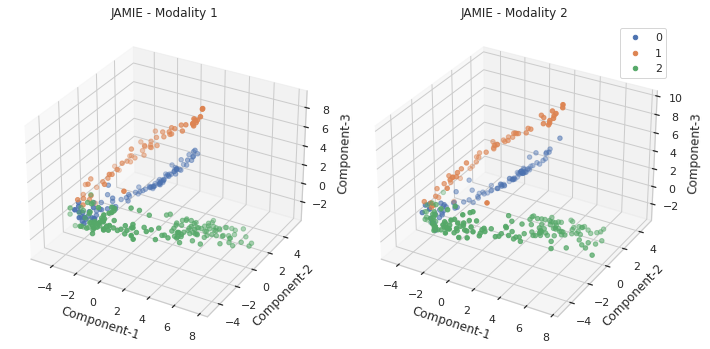

In [13]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

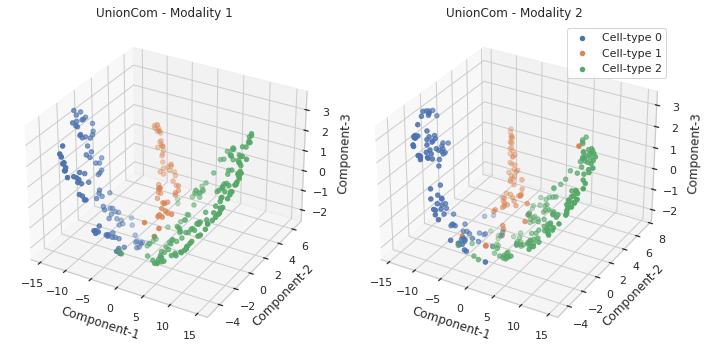

In [46]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(uc_data, labels, ['UnionCom - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-UnionCom.png')

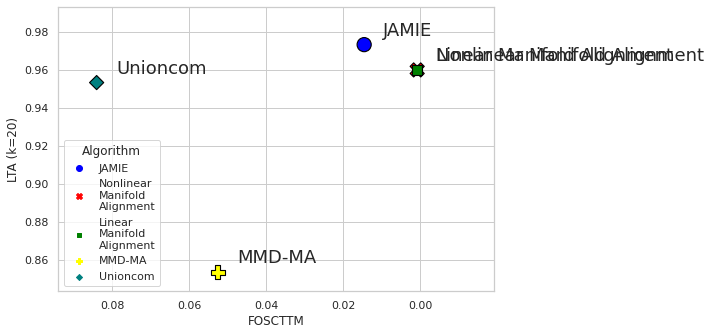

In [98]:
plt.figure(figsize=(10, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, exclude=[3], colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

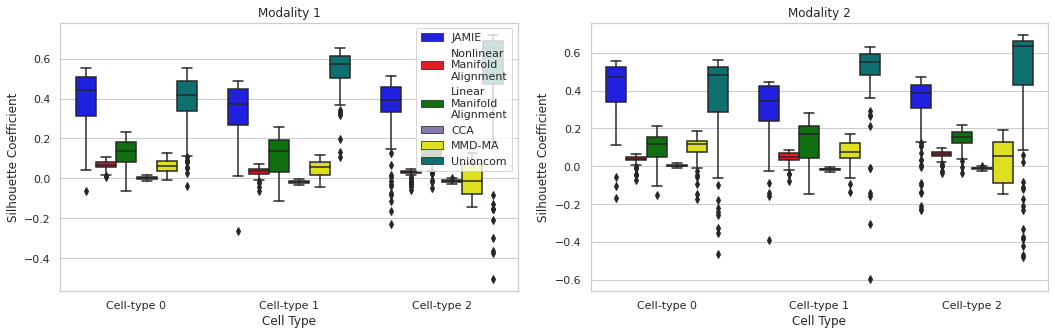

In [37]:
plt.figure(figsize=(15, 5))
plot_silhouette(integrated_data, labels, integrated_names, modality_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

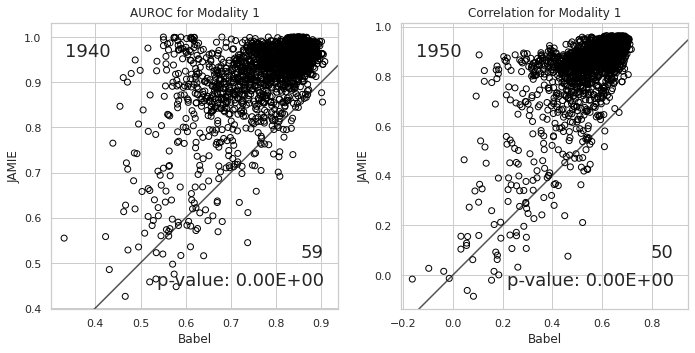

In [17]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

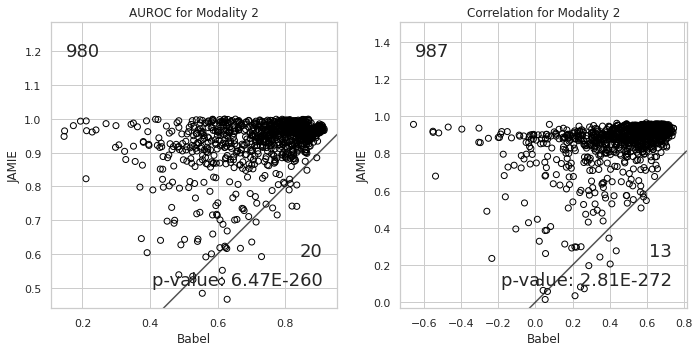

In [18]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

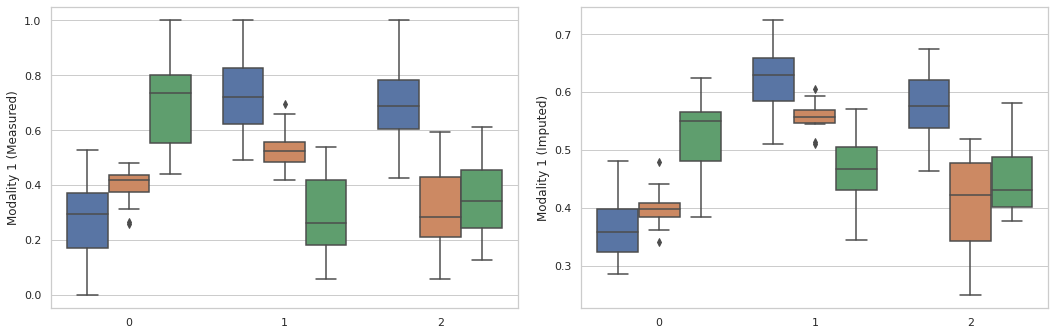

In [45]:
plt.figure(figsize=(15, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], supert=modality_names[0], fnames=2*[features[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

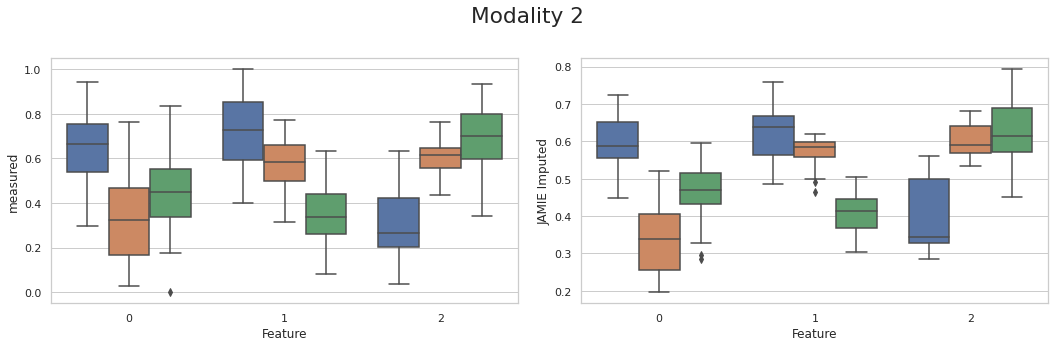

In [20]:
plt.figure(figsize=(15, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], supert=modality_names[1], fnames=2*[features[1]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

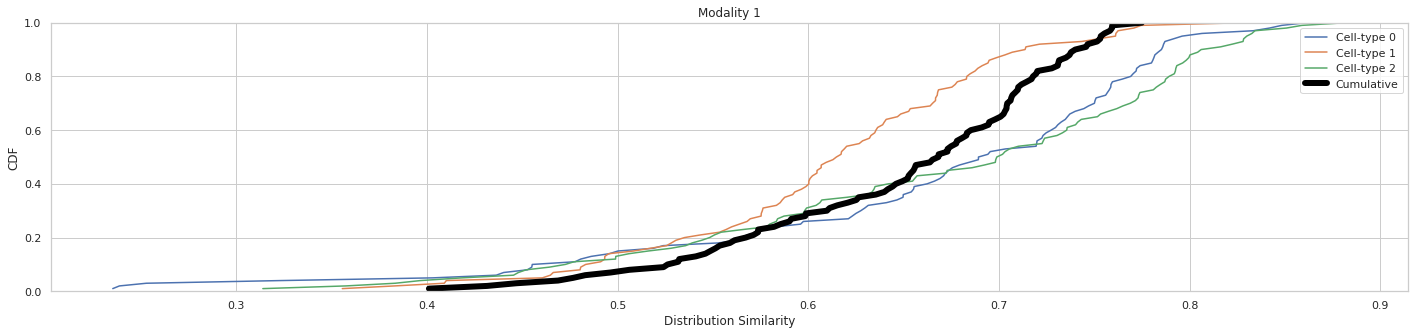

In [85]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png')

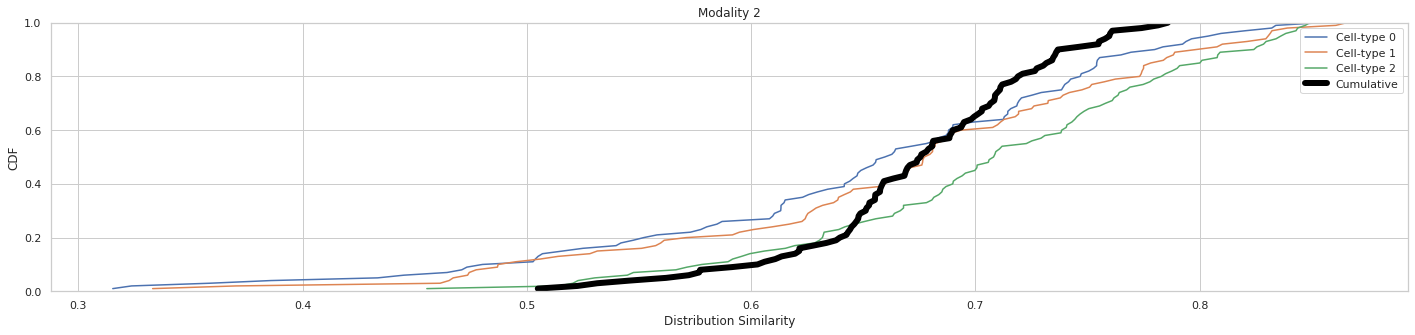

In [86]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png')

# Explanation

In [23]:
# Integration
kwargs = {
    'output_dim': 1,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm_thin = ComManDo(**kwargs)
cm_thin_data = cm_thin.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.8003 alpha:0.4901
epoch:[1000/2000] err:2.8913 alpha:0.5653
epoch:[1500/2000] err:2.7699 alpha:0.5941
epoch:[2000/2000] err:2.7564 alpha:0.6109
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.850454
epoch:[1000/2000]: loss:1.472363
epoch:[1500/2000]: loss:1.360671
epoch:[2000/2000]: loss:1.273202
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.13841964199673384
Correspondence: 7.089157213980798
Mapping: 54.616099892999046
Total: 61.84367674897658



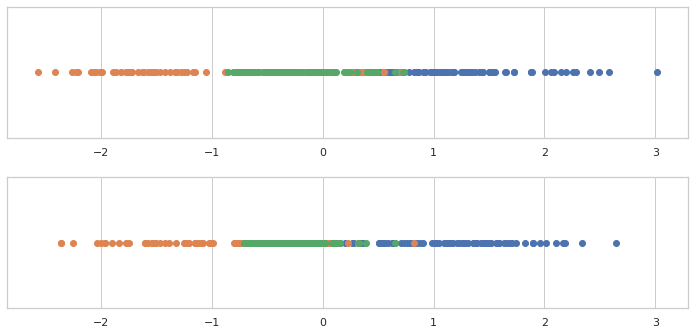

In [24]:
plt.figure(figsize=(10, 5))
axs = plt.gcf().subplots(2, 1)
for i, ax in enumerate(axs):
    for l in np.unique(np.concatenate(labels)):
        ax.scatter(cm_thin_data[i][labels[i] == l], np.zeros_like(cm_thin_data[i][labels[i] == l]), label=l)
    ax.set_yticks([])
min_lim = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
max_lim = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
for ax in axs:
    ax.set_xlim([min_lim, max_lim])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Line.png');

In [25]:
%%capture
import shap

def join_data(data):
    return np.concatenate(data, axis=1)
def sep_data(data, split):
    return [data[:, :split], data[:, split:]]
def detach_data(data):
    return [x.detach() for x in data]
def make_tens(data):
    return [torch.Tensor(x) for x in data]
def prep_data(data, m):
    return [m.preprocessing[i](x) for i, x in enumerate(data)]

target_feature = 0
if pca_dim is not None and pca_dim[0] is not None:
    split = pca_dim[0]
else:
    split = dataset[0].shape[1]
# model = lambda x: join_data(detach_data( cm.model(*make_tens(prep_data(sep_data(x, split), cm.model)), corr=torch.Tensor(np.eye(len(x))))[0] ))[:, target_feature]
# data = join_data(dataset)
model = lambda x: join_data(detach_data( cm_thin.model(*make_tens(sep_data(x, split)), corr=torch.Tensor(np.eye(len(x))))[0] ))[:, target_feature]
data = join_data(prep_data(dataset, cm_thin.model))

explainer = shap.KernelExplainer(model, shap.kmeans(data, 10))
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    shap_values = explainer.shap_values(data, nsamples=100)

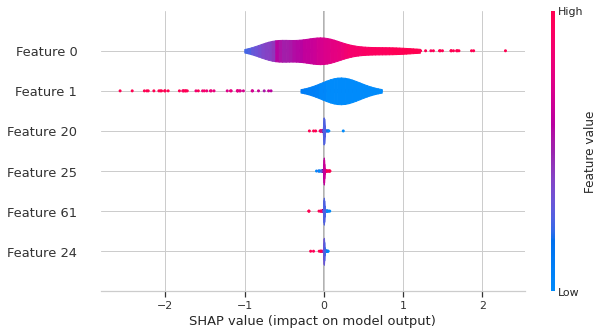

In [26]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=6, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

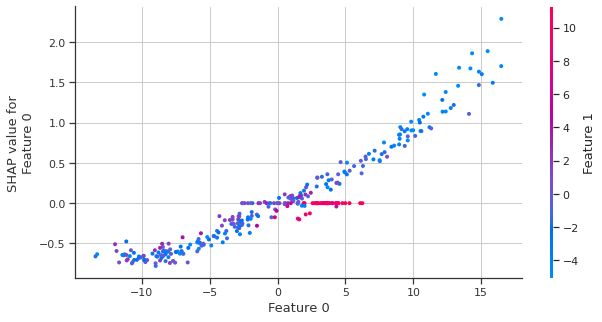

In [27]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(0, shap_values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dependence.png');

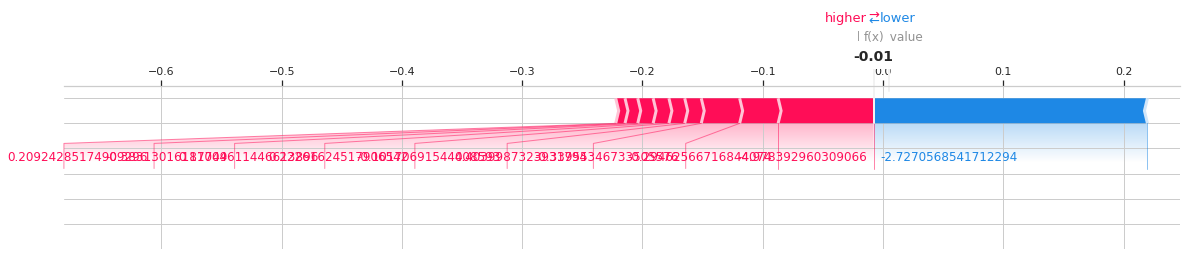

In [28]:
# shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], data[0, :], matplotlib=True, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data)